# Principal Component Analysis (PCA) for Coinbase, Bitcoin, and Ethereum

## 1. Introduction  

**Overview:** This notebook explores the relationship between Coinbase, Bitcoin, and Ethereum using Principal Component Analysis (PCA). The goal is to identify the principal components that explain the majority of the variance in the data.  
**Research Question:** What are the principal components that explain the majority of the variance in the data for Coinbase, Bitcoin, and Ethereum that can be used to predict future prices and log returns?

In [18]:
# Import the required libraries
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from tabulate import tabulate

# Set defaults for high resolution displays
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (10, 6)
plt.style.use("default")

## 2. Data Acquisition and Preprocessing

**Data Sources:** The data for Coinbase, Bitcoin, and Ethereum is obtained from Yahoo Finance, and the economic data is obtained from the Federal Reserve Economic Data (FRED) database. Both datasets are from Apri 1, 2021 to June 25, 2024.  

In [2]:
def fetch_yahoo_data(tickers, start_date, end_date):
    """Fetches financial data from Yahoo Finance."""
    df = yf.download(tickers, start=start_date, end=end_date)
    df = df.ffill().resample("D").ffill()
    df.columns = ["_".join(col).strip() for col in df.columns.values]
    return df


def clean_data(df):
    """Cleans the data by dropping unnecessary columns."""
    df = df.drop(
        columns=[col for col in df.columns if "Close" in col and "Adj" not in col]
    )
    if "Volume_DX-Y.NYB" in df.columns:
        df = df.drop(columns=["Volume_DX-Y.NYB"])
    return df


def create_column_mapping(tickers):
    """Creates a mapping for column renaming."""
    column_mapping = {}
    asset_names = {
        "COIN": "coinbase",
        "BTC-USD": "bitcoin",
        "ETH-USD": "ethereum",
        "GC=F": "gold",
        "DX-Y.NYB": "us_dollar_index",
    }
    columns = ["Adj Close", "High", "Low", "Open", "Volume"]

    for ticker in tickers:
        asset = asset_names.get(ticker, ticker)
        for col in columns:
            old_col = f"{col}_{ticker}"
            if col == "Adj Close":
                new_col = f"{asset}_price"
            else:
                new_col = f"{asset}_{col.lower().replace(' ', '_')}"
            column_mapping[old_col] = new_col

    return column_mapping


def rename_columns(df, column_mapping):
    """Renames the columns based on the provided mapping."""
    return df.rename(columns=column_mapping)


def calculate_returns(df):
    """Calculates daily returns for specific assets."""
    assets = ["bitcoin", "coinbase", "ethereum", "gold"]

    for asset in assets:
        price_col = f"{asset}_price"
        if price_col in df.columns:
            # Calculate simple returns
            df[f"{asset}_return"] = df[price_col].pct_change()
            # Calculate log returns
            df[f"{asset}_log_return"] = np.log(df[price_col] / df[price_col].shift(1))
        else:
            print(
                f"Warning: {price_col} not found in dataframe. Skipping return calculation."
            )
    return df


def order_columns(df):
    """Orders the columns with key columns at the front."""
    key_columns = ["coinbase_price", "bitcoin_price", "ethereum_price"]
    remaining_columns = [col for col in df.columns if col not in key_columns]
    return df[key_columns + remaining_columns]


def fetch_and_process_financial_data(tickers, start_date, end_date):
    """Main function to fetch and process financial data."""
    df = fetch_yahoo_data(tickers, start_date, end_date)
    df = clean_data(df)
    column_mapping = create_column_mapping(tickers)
    df = rename_columns(df, column_mapping)
    df = calculate_returns(df)
    df = order_columns(df)
    return df

In [3]:
def fetch_and_resample_fred(series_id, start_date, end_date, freq="D"):
    """Fetches data from FRED (Federal Reserve Economic Data) and resamples it to a daily frequency."""
    try:
        data = (
            pdr.get_data_fred(series_id, start_date, end_date)
            .ffill()
            .resample(freq)
            .ffill()
        )
        # Reindex the data to include all days between start_date and end_date
        data = data.reindex(pd.date_range(start_date, end_date, freq="D"))
        data = data.ffill().bfill()
        return data
    except Exception as e:
        print(f"Error fetching {series_id}: {e}")
        return None

### Fetch financial data from Yahoo Finance

In [4]:
# Define the tickers to fetch
tickers = ["COIN", "BTC-USD", "ETH-USD", "GC=F", "DX-Y.NYB"]

# Define the date range
start_date = datetime(2021, 4, 14)  # Date of Coinbase IPO
end_date = datetime(2024, 6, 25)

# Fetch and process the financial data
financial_data = fetch_and_process_financial_data(tickers, start_date, end_date)

# Display the first few rows of the financial data
financial_data.head()

[*********************100%%**********************]  5 of 5 completed


,coinbase_price,bitcoin_price,ethereum_price,us_dollar_index_price,gold_price,bitcoin_high,coinbase_high,us_dollar_index_high,ethereum_high,gold_high,...,ethereum_volume,gold_volume,bitcoin_return,bitcoin_log_return,coinbase_return,coinbase_log_return,ethereum_return,ethereum_log_return,gold_return,gold_log_return
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-14,328.279999,63109.695312,2435.104980,91.690002,1734.900024,64863.097656,429.540009,91.830002,2449.687500,1745.900024,...,35592822986,1037.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-15,322.750000,63314.011719,2519.116211,91.669998,1765.400024,63821.671875,349.200012,91.750000,2544.267334,1767.900024,...,32325606817,368.0,0.003237,0.003232,-0.016845,-0.016989,0.034500,0.033918,0.017580,0.017428
2021-04-16,342.000000,61572.789062,2431.946533,91.559998,1779.000000,63594.722656,345.989990,91.809998,2547.555664,1779.500000,...,36196928256,625.0,-0.027501,-0.027887,0.059644,0.057933,-0.034603,-0.035216,0.007704,0.007674
2021-04-17,342.000000,60683.820312,2344.895020,91.559998,1779.000000,62572.175781,345.989990,91.809998,2497.385254,1779.500000,...,32349808978,625.0,-0.014438,-0.014543,0.000000,0.000000,-0.035795,-0.036451,0.000000,0.000000
2021-04-18,342.000000,56216.183594,2237.136963,91.559998,1779.000000,61057.457031,345.989990,91.809998,2365.460449,1779.500000,...,50696368718,625.0,-0.073622,-0.076472,0.000000,0.000000,-0.045954,-0.047044,0.000000,0.000000


### Fetch the economic data from FRED

In [5]:
# Define a dictionary mapping FRED series IDs to desired column names
fred_data_mapping = {
    "FEDFUNDS": "fed_funds_rate",
    "DSPIC96": "real_disposable_income",
    "GDPC1": "real_gdp",
    "UNRATE": "unemployment_rate",
    "UMCSENT": "michigan_sentiment",
    "CPILFESL": "core_cpi",
    "PPIACO": "producer_price_index",
    "WM2NS": "m2_money_supply",
}

# List of treasury yields to fetch
treasuries = [
    "DGS3MO",
    "DGS6MO",
    "DGS1",
    "DGS2",
    "DGS3",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS20",
    "DGS30",
]

# Initialize an empty list to store DataFrames
econ_data_list = []

# Fetch and process data from FRED
for series_id, col_name in fred_data_mapping.items():
    data = fetch_and_resample_fred(series_id, start_date, end_date)
    if data is not None:
        data = data.rename(columns={series_id: col_name})
        econ_data_list.append(data)
    else:
        print(f"Failed to fetch data for {series_id}")

# Fetch and process treasury data
treasuries_data = fetch_and_resample_fred(treasuries, start_date, end_date)
if treasuries_data is not None:
    econ_data_list.append(treasuries_data)
else:
    print("Failed to fetch treasury data")

# Combine all economic data into a single DataFrame
if econ_data_list:
    # Create a common date range for all data
    date_range = pd.date_range(start=start_date, end=end_date, freq="D")

    # Reindex all DataFrames to the common date range
    econ_data_list = [df.reindex(date_range) for df in econ_data_list]

    # Concatenate all DataFrames
    econ_data = pd.concat(econ_data_list, axis=1)

    # Calculate the yield curve spread
    if "DGS10" in econ_data.columns and "DGS2" in econ_data.columns:
        econ_data["yield_curve_spread"] = econ_data["DGS10"] - econ_data["DGS2"]

    # Check for and report any missing data
    missing_data = econ_data.isnull().sum()
    if missing_data.any():
        print("Missing data in the following columns:")
        print(missing_data[missing_data > 0])

    # Show the economic data
    print(econ_data.head())
else:
    print("No economic data was successfully fetched.")

            fed_funds_rate  real_disposable_income   real_gdp  \
2021-04-14            0.06                 16819.1  21483.083   
2021-04-15            0.06                 16819.1  21483.083   
2021-04-16            0.06                 16819.1  21483.083   
2021-04-17            0.06                 16819.1  21483.083   
2021-04-18            0.06                 16819.1  21483.083   

            unemployment_rate  michigan_sentiment  core_cpi  \
2021-04-14                5.8                82.9   275.494   
2021-04-15                5.8                82.9   275.494   
2021-04-16                5.8                82.9   275.494   
2021-04-17                5.8                82.9   275.494   
2021-04-18                5.8                82.9   275.494   

            producer_price_index  m2_money_supply  DGS3MO  DGS6MO  DGS1  DGS2  \
2021-04-14                 224.9          20280.6    0.02    0.04  0.06  0.16   
2021-04-15                 224.9          20280.6    0.02    0.04  0

### Combine the financial and economic data and perform feature engineering

In [6]:
def add_technical_indicators(df, asset_name):
    """Add technical indicators to the DataFrame."""
    price = df[f"{asset_name}_price"]
    volume = df[f"{asset_name}_volume"]
    high = df[f"{asset_name}_high"]
    low = df[f"{asset_name}_low"]

    # Define the lagged values of the price and volume
    for lag in [1, 5, 10]:
        df[f"{asset_name}_price_lag_{lag}"] = price.shift(lag)
        df[f"{asset_name}_volume_lag_{lag}"] = volume.shift(lag)

    # Calculate the simple and exponential moving averages
    for window in [5, 10, 20, 50, 100]:
        df[f"{asset_name}_sma_{window}"] = price.rolling(window=window).mean()
        df[f"{asset_name}_ema_{window}"] = price.ewm(span=window, adjust=False).mean()

    # Calculate the differences
    for window in [5, 10, 20, 50, 100]:
        df[f"{asset_name}_sma_{window}_diff"] = df[f"{asset_name}_sma_{window}"].diff()
        df[f"{asset_name}_ema_{window}_diff"] = df[f"{asset_name}_ema_{window}"].diff()

    # Calculate the open-close range
    df[f"{asset_name}_range"] = high - low

    # Calculate the RSI
    delta = price.diff()
    average_gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    average_loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    relative_strength = average_gain / average_loss
    df[f"{asset_name}_rsi"] = 100 - (100 / (1 + relative_strength))

    # Calculate the MACD
    exp1 = price.ewm(span=12, adjust=False).mean()
    exp2 = price.ewm(span=26, adjust=False).mean()
    df[f"{asset_name}_macd"] = exp1 - exp2

    # Calculate the MACD Signal
    df[f"{asset_name}_macd_signal"] = (
        df[f"{asset_name}_macd"].ewm(span=9, adjust=False).mean()
    )

    # Calculate the MACD Histogram
    df[f"{asset_name}_macd_hist"] = (
        df[f"{asset_name}_macd"] - df[f"{asset_name}_macd_signal"]
    )

    # Calculate the Average True Range (ATR)
    df[f"{asset_name}_tr0"] = abs(high - low)
    df[f"{asset_name}_tr1"] = abs(high - df[f"{asset_name}_price_lag_1"])
    df[f"{asset_name}_tr2"] = abs(low - df[f"{asset_name}_price_lag_1"])
    df[f"{asset_name}_tr"] = df[
        [f"{asset_name}_tr0", f"{asset_name}_tr1", f"{asset_name}_tr2"]
    ].max(axis=1)
    df[f"{asset_name}_atr"] = df[f"{asset_name}_tr"].rolling(window=14).mean()

    # Drop rows with NaN values
    df = df.dropna()

    return df


def prepare_asset_data(financial_data, econ_data, asset_prefix, add_technical_indicators):
    """Prepare data for a given asset by selecting relevant columns, merging with economic data, then adding technical indicators."""
    asset_data = financial_data[
        [
            f"{asset_prefix}_price",
            f"{asset_prefix}_volume",
            f"{asset_prefix}_log_return",
            f"{asset_prefix}_high",
            f"{asset_prefix}_low",
            f"{asset_prefix}_open",
            "gold_price",
            "us_dollar_index_price",
        ]
    ].copy()

    # Merge with economic data
    asset_data = pd.concat([asset_data, econ_data], axis=1)

    # Add technical indicators
    asset_data = add_technical_indicators(asset_data, asset_prefix)

    X = asset_data.drop(columns=[f"{asset_prefix}_price", f"{asset_prefix}_log_return"])
    y = asset_data[[f"{asset_prefix}_price", f"{asset_prefix}_log_return"]]

    return X, y

### Slice the data so only features are included

In [7]:
# Define X and y for Coinbase stock
X_coinbase, y_coinbase = prepare_asset_data(
    financial_data, econ_data, "coinbase", add_technical_indicators
)

# Define X and y for Bitcoin
X_bitcoin, y_bitcoin = prepare_asset_data(
    financial_data, econ_data, "bitcoin", add_technical_indicators
)

# Define X and y for Ethereum
X_ethereum, y_ethereum = prepare_asset_data(
    financial_data, econ_data, "ethereum", add_technical_indicators
)

# Separate the y data into price and log return
y_coinbase_price = y_coinbase["coinbase_price"]
y_coinbase_log_ret = y_coinbase["coinbase_log_return"]

y_bitcoin_price = y_bitcoin["bitcoin_price"]
y_bitcoin_log_ret = y_bitcoin["bitcoin_log_return"]

y_ethereum_price = y_ethereum["ethereum_price"]
y_ethereum_log_ret = y_ethereum["ethereum_log_return"]

## 3. Principal Component Analysis (PCA)

In [8]:
def generate_interaction_terms(X, degree=2):
    """Generates interaction terms for the feature set."""
    # Initialize the polynomial features transformer
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)

    # Generate the polynomial features
    interaction_data = poly.fit_transform(X)

    # Get the feature names
    interaction_feature_names = poly.get_feature_names_out(X.columns)

    # Create a DataFrame
    interaction_df = pd.DataFrame(interaction_data, columns=interaction_feature_names)

    return interaction_df


def perform_pca(X, n_components, include_interactions=False):
    """Performs PCA on the feature set with optional interaction terms."""
    if include_interactions:
        # Generate interaction terms
        X = generate_interaction_terms(X)

    # Initialize the standard scaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)

    return pca, principal_components


def explained_variance(pca):
    """Calculates the explained variance for each principal component."""
    # Calculate the explained variance for each principal component
    explained_variance = pca.explained_variance_ratio_

    # Generate the cumulative explained variance
    cum_explained_variance = np.cumsum(explained_variance)

    return explained_variance, cum_explained_variance


def plot_explained_variance(explained_variance, cum_explained_variance):
    """Plots the explained variance and cumulative explained variance."""
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Ensure the cumulative explained variance does not exceed 100%
    cum_explained_variance = np.minimum(cum_explained_variance, 1.0)

    # Plot the explained variance
    ax.bar(
        range(1, len(explained_variance) + 1),
        explained_variance * 100.0,  # Convert to percentage
        alpha=0.7,
        align="center",
        label="Explained Variance",
        color="tab:blue",
    )
    ax.step(
        range(1, len(cum_explained_variance) + 1),
        cum_explained_variance * 100.0,  # Convert to percentage
        where="mid",
        label="Cumulative Explained Variance",
        color="tab:orange",
        linewidth=2,
    )

    # Add labels and title
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Explained Variance Ratio (%)")
    ax.set_title("Explained Variance Ratio for Principal Components")
    ax.legend(loc="upper left")

    # Set y-axis to percentage
    ax.set_ylim(0.0, 100.0)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

    # Display the plot
    plt.tight_layout()
    plt.show()

In [9]:
# Perform PCA on the X data for Coinbase
coinbase_pca, coinbase_principal_components = perform_pca(
    X_coinbase, n_components=3, include_interactions=False
)

# Calculate the explained variance
coinbase_exp_var, coinbase_cum_exp_var = explained_variance(coinbase_pca)

# Perform PCA on the X data for Bitcoin
bitcoin_pca, bitcoin_principal_components = perform_pca(
    X_bitcoin, n_components=3, include_interactions=False
)

# Calculate the explained variance
bitcoin_exp_var, bitcoin_cum_exp_var = explained_variance(bitcoin_pca)

# Perform PCA on the X data for Ethereum
ethereum_pca, ethereum_principal_components = perform_pca(
    X_ethereum, n_components=3, include_interactions=False
)

# Calculate the explained variance
ethereum_exp_var, ethereum_cum_exp_var = explained_variance(ethereum_pca)

## 4. Visualization and Interpretation

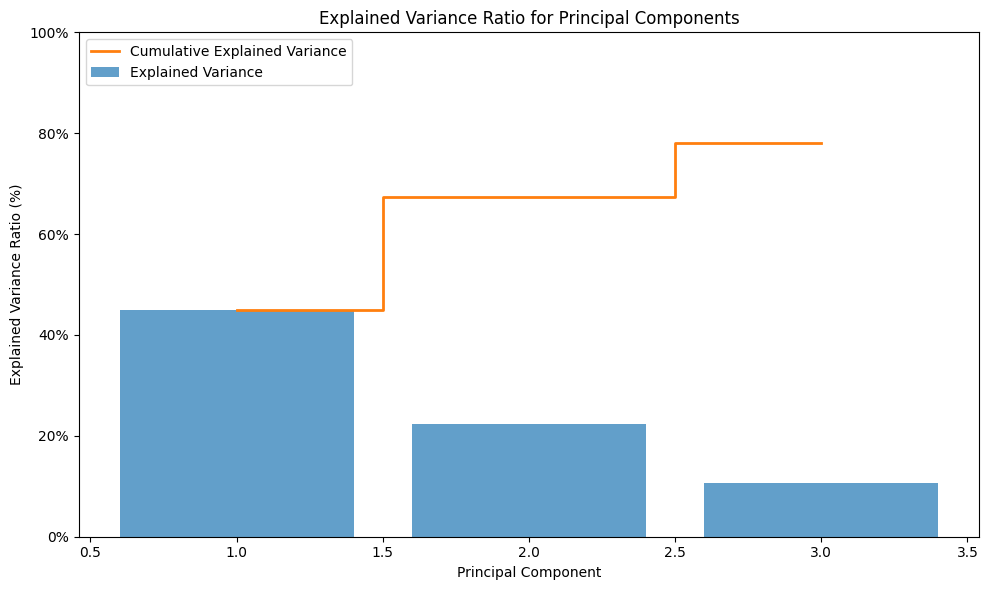

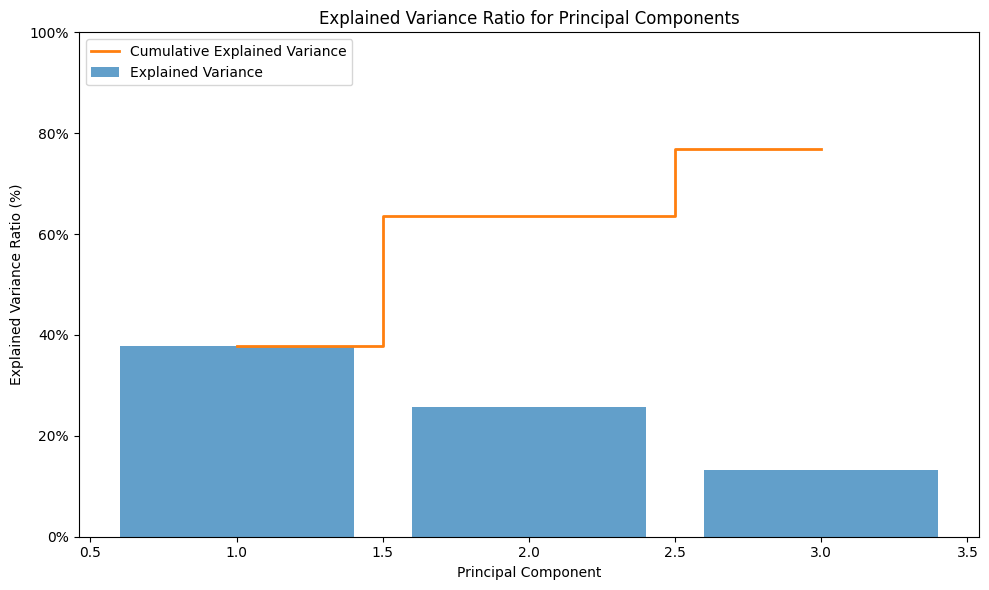

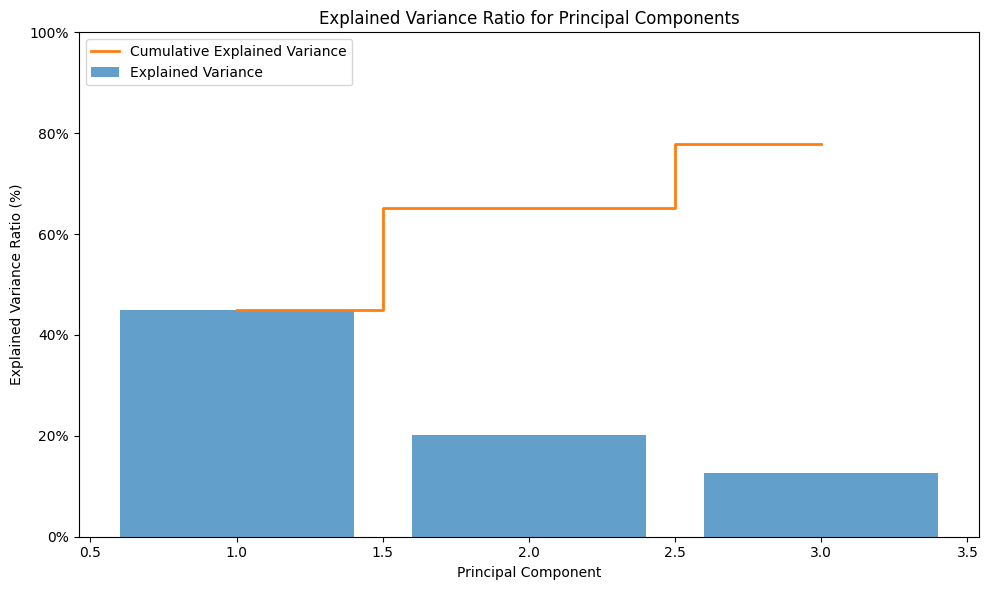

In [10]:
# Plot the explained variance for Coinbase
plot_explained_variance(coinbase_exp_var, coinbase_cum_exp_var)

# Plot the explained variance for Bitcoin
plot_explained_variance(bitcoin_exp_var, bitcoin_cum_exp_var)

# Plot the explained variance for Ethereum
plot_explained_variance(ethereum_exp_var, ethereum_cum_exp_var)

### Interpret the results from the loadings and scores

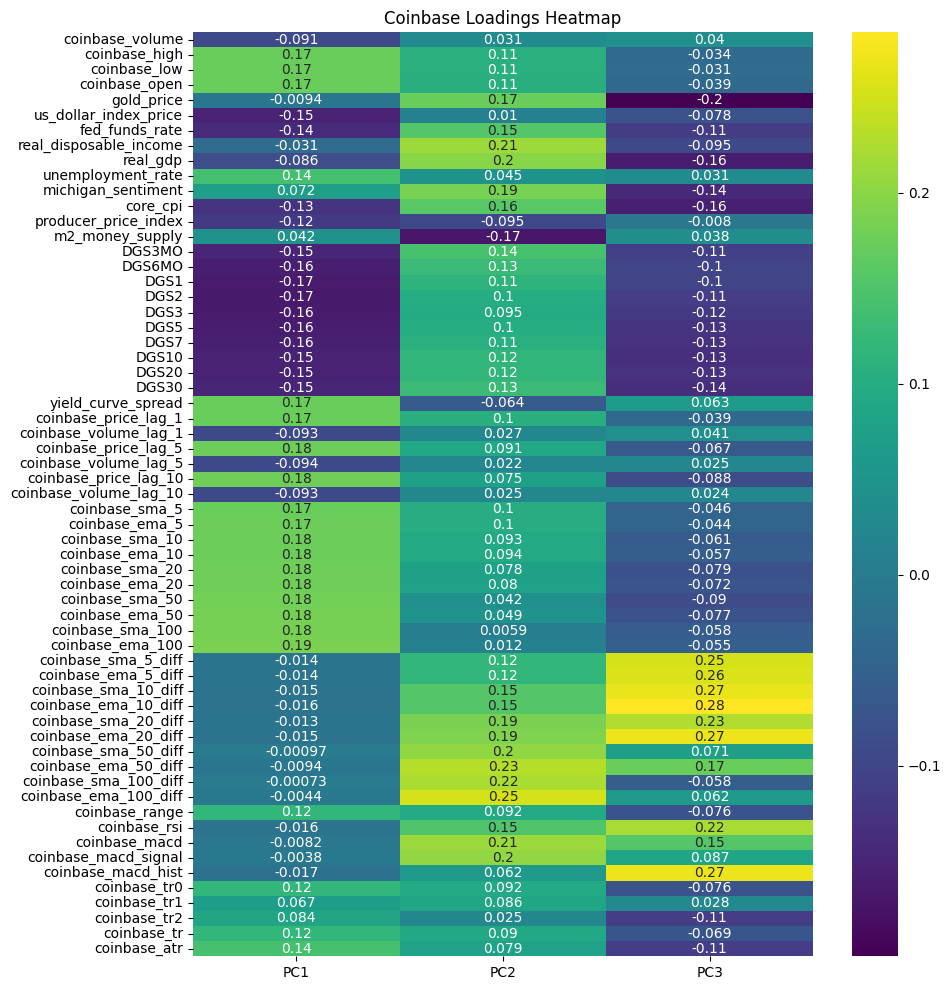

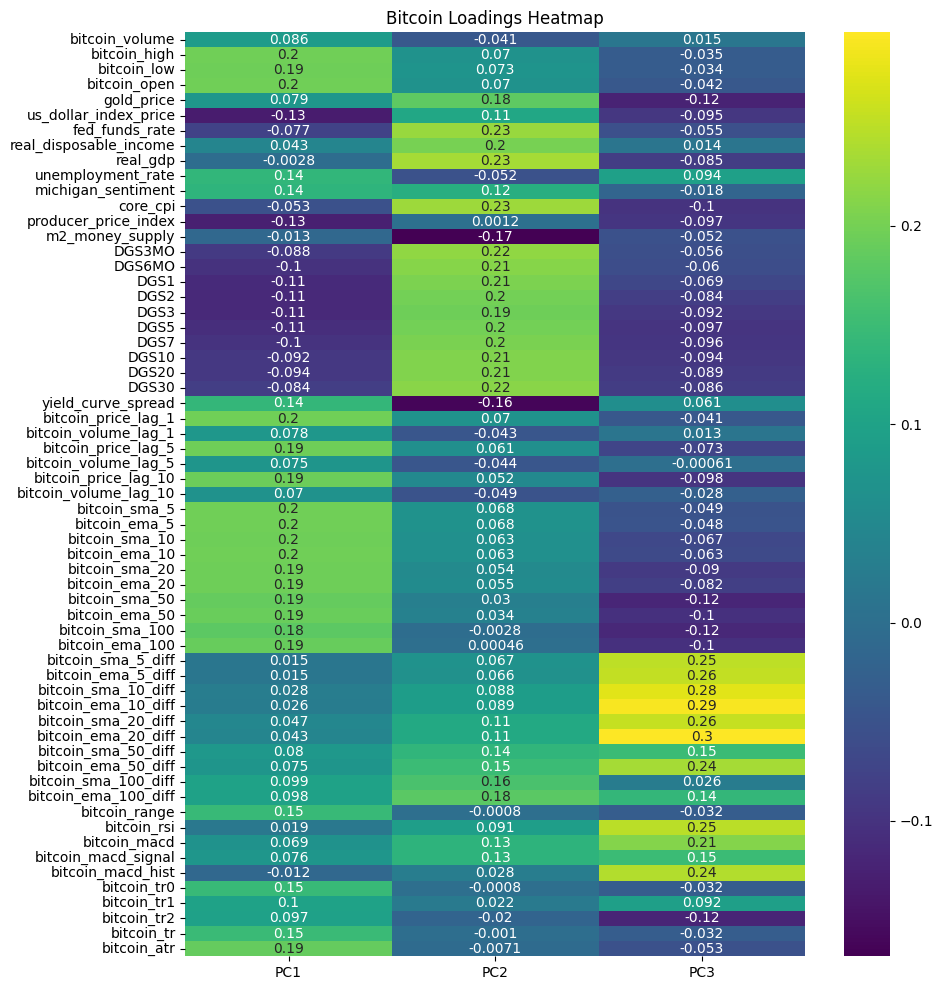

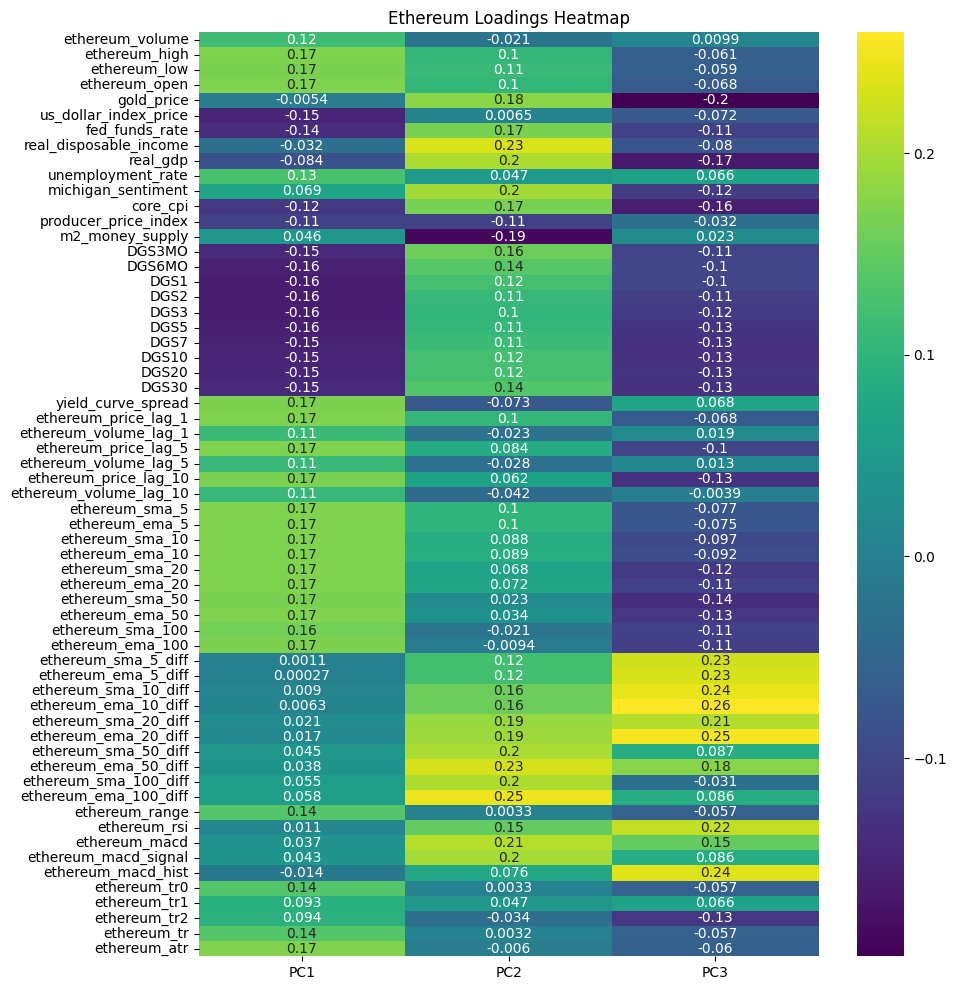

In [11]:
# Generate interaction terms for the feature names as well
def get_feature_names_with_interactions(X):
    """Generate feature names including interaction terms."""
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly.fit(X)  # Fit to get feature names
    return poly.get_feature_names_out(X.columns)


# Get feature names for the original and interaction terms
coinbase_feature_names = get_feature_names_with_interactions(X_coinbase)
bitcoin_feature_names = get_feature_names_with_interactions(X_bitcoin)
ethereum_feature_names = get_feature_names_with_interactions(X_ethereum)

# Get the loadings (components) for each asset
coinbase_loadings = coinbase_pca.components_
bitcoin_loadings = bitcoin_pca.components_
ethereum_loadings = ethereum_pca.components_

# Create DataFrames for the loadings
coinbase_loadings_df = pd.DataFrame(
    coinbase_loadings.T,
    columns=[f"PC{i+1}" for i in range(coinbase_loadings.shape[0])],
    index=X_coinbase.columns,
)

bitcoin_loadings_df = pd.DataFrame(
    bitcoin_loadings.T,
    columns=[f"PC{i+1}" for i in range(bitcoin_loadings.shape[0])],
    index=X_bitcoin.columns,
)

ethereum_loadings_df = pd.DataFrame(
    ethereum_loadings.T,
    columns=[f"PC{i+1}" for i in range(ethereum_loadings.shape[0])],
    index=X_ethereum.columns,
)

# Plot heatmap for Coinbase loadings
plt.figure(figsize=(10, 12))
sns.heatmap(coinbase_loadings_df, annot=True, cmap="viridis")
plt.title("Coinbase Loadings Heatmap")
plt.show()

# Plot heatmap for Bitcoin loadings
plt.figure(figsize=(10, 12))
sns.heatmap(bitcoin_loadings_df, annot=True, cmap="viridis")
plt.title("Bitcoin Loadings Heatmap")
plt.show()

# Plot heatmap for Ethereum loadings
plt.figure(figsize=(10, 12))
sns.heatmap(ethereum_loadings_df, annot=True, cmap="viridis")
plt.title("Ethereum Loadings Heatmap")
plt.show()

### Component Loadings

In [12]:
def get_top_features(loadings_df, component, top_n=10):
    """Get the top features for a given principal component."""
    abs_loadings = np.abs(loadings_df[component])
    top_features = abs_loadings.nlargest(top_n)
    return pd.DataFrame(
        {
            "Feature": top_features.index,
            "Loading": loadings_df.loc[top_features.index, component],
            "Abs_Loading": top_features.values,
        }
    )


def analyze_pca_loadings(loadings_df, asset_name, top_n=10, num_components=3):
    """Analyze PCA loadings for a given asset."""
    results = []
    for i in range(1, num_components + 1):
        pc = f"PC{i}"
        top_features = get_top_features(loadings_df, pc, top_n)
        results.append(
            {"Asset": asset_name, "Component": pc, "Top_Features": top_features}
        )
    return results


def print_table(data, title):
    """Print a formatted table."""
    print(f"\n{title}")
    print(
        tabulate(data, headers="keys", tablefmt="pipe", floatfmt=".4f", showindex=False)
    )


# Analyze loadings for each asset
assets = [
    ("Coinbase", coinbase_loadings_df),
    ("Bitcoin", bitcoin_loadings_df),
    ("Ethereum", ethereum_loadings_df),
]

all_results = []
for asset_name, loadings_df in assets:
    all_results.extend(analyze_pca_loadings(loadings_df, asset_name))

# Print tables for each asset and component
for result in all_results:
    title = f"{result['Asset']} - Top 10 Features for {result['Component']}"
    print_table(result["Top_Features"], title)

# Generate a summary table
summary_data = []
for result in all_results:
    top_feature = result["Top_Features"].iloc[0]
    summary_data.append(
        {
            "Asset": result["Asset"],
            "Component": result["Component"],
            "Top_Feature": top_feature["Feature"],
            "Loading": top_feature["Loading"],
        }
    )

print_table(summary_data, "Summary of Top Features Across Assets and Components")


Coinbase - Top 10 Features for PC1
| Feature               |   Loading |   Abs_Loading |
|:----------------------|----------:|--------------:|
| coinbase_ema_100      |    0.1858 |        0.1858 |
| coinbase_sma_100      |    0.1828 |        0.1828 |
| coinbase_ema_50       |    0.1821 |        0.1821 |
| coinbase_sma_50       |    0.1806 |        0.1806 |
| coinbase_ema_20       |    0.1780 |        0.1780 |
| coinbase_sma_20       |    0.1776 |        0.1776 |
| coinbase_price_lag_10 |    0.1766 |        0.1766 |
| coinbase_ema_10       |    0.1758 |        0.1758 |
| coinbase_sma_10       |    0.1756 |        0.1756 |
| coinbase_price_lag_5  |    0.1753 |        0.1753 |

Coinbase - Top 10 Features for PC2
| Feature                |   Loading |   Abs_Loading |
|:-----------------------|----------:|--------------:|
| coinbase_ema_100_diff  |    0.2523 |        0.2523 |
| coinbase_ema_50_diff   |    0.2305 |        0.2305 |
| coinbase_sma_100_diff  |    0.2221 |        0.2221 |
| rea

### PCA Scatter Plot

In [13]:
def create_pca_scatter_plots(principal_components, target, asset_name):
    """
    Create PCA scatter plots for a given asset.
    
    Args:
        principal_components: numpy array of principal components
        target: pandas Series of target values
        asset_name: string, name of the asset
    
    Returns:
        Altair Chart object with three scatter plots
    """
    # Enable the 'fivethirtyeight' theme
    alt.themes.enable("fivethirtyeight")

    # Create a DataFrame for the principal components
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=[f"PC{i+1}" for i in range(3)]
    )
    
    # Add the target variable to the DataFrame
    pca_df[f"{asset_name}_price"] = target.values
    
    # Base chart
    base = alt.Chart(pca_df).mark_circle(size=60).encode(
        color=alt.Color(f"{asset_name}_price", title=f"{asset_name.capitalize()} Price"),
        tooltip=[f"{asset_name}_price"]
    )
    
    # Create three scatter plots
    plots = []
    for i, j in [(1, 2), (1, 3), (2, 3)]:
        plot = base.encode(
            x=f"PC{i}",
            y=f"PC{j}"
        ).properties(
            width=300,
            height=300,
        )
        plots.append(plot)
    
    # Combine the plots
    return alt.hconcat(*plots)

# List of assets
assets = [
    ("coinbase", coinbase_principal_components, y_coinbase["coinbase_price"]),
    ("bitcoin", bitcoin_principal_components, y_bitcoin["bitcoin_price"]),
    ("ethereum", ethereum_principal_components, y_ethereum["ethereum_price"])
]

# Create plots for all assets
all_plots = []
for asset_name, principal_components, target in assets:
    asset_plots = create_pca_scatter_plots(principal_components, target, asset_name)
    all_plots.append(asset_plots)

# Combine all plots vertically
final_chart = alt.vconcat(*all_plots).resolve_scale(color="independent")

# Display the final chart
final_chart.properties(
    title="PCA Scatter Plots for Coinbase, Bitcoin, and Ethereum"
).configure_title(
    anchor="start",
)

alt.VConcatChart(...)

## 5. Regression Analysis with PCA Components

In [14]:
# Define the features (using the first three principal components)
datasets = {
    "coinbase": (coinbase_principal_components[:, :3], y_coinbase_log_ret),
    "bitcoin": (bitcoin_principal_components[:, :3], y_bitcoin_log_ret),
    "ethereum": (ethereum_principal_components[:, :3], y_ethereum_log_ret),
}

### Linear Regression with PCA Components (Baseline Model)

In [15]:
def fit_linear_regression_model(X, y):
    """Fit a linear regression model."""
    model = LinearRegression()
    model.fit(X, y)
    return model

# Fit linear regression models and calculate R-squared values
linreg_results = {}
for asset, (X, y) in datasets.items():
    model = fit_linear_regression_model(X, y)
    r2 = model.score(X, y)
    linreg_results[asset] = {"model": model, "r2": r2}

# Display the R-squared values
linreg_r2_values = {asset: result["r2"] for asset, result in linreg_results.items()}
print(linreg_r2_values)

{'coinbase': 0.1377756949613791, 'bitcoin': 0.17338286213752319, 'ethereum': 0.16662730733078535}


### Polynomial Regression with PCA Components (Improved Model)

In [16]:
def fit_polyreg_model(X, y, degree=2):
    """Fit a polynomial regression model."""
    # Initialize the polynomial features transformer
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    # Generate the polynomial features
    X_poly = poly.fit_transform(X)

    # Initialize and fit the polynomial regression model
    polyreg = LinearRegression()
    polyreg.fit(X_poly, y)

    return poly, polyreg


# Fit polynomial regression models for each asset and Calculate R-squared values
poly_reg_results = {}
for asset, (X, y) in datasets.items():
    poly, polyreg = fit_polyreg_model(X, y, degree=2)
    r2 = polyreg.score(poly.transform(X), y)
    poly_reg_results[asset] = {"poly": poly, "polyreg": polyreg, "r2": r2}

# Display the R-squared values
poly_r2_values = {asset: result["r2"] for asset, result in poly_reg_results.items()}
print(poly_r2_values)

{'coinbase': 0.1704840877297511, 'bitcoin': 0.19871178354023733, 'ethereum': 0.1998635380125522}


### Random Forest Regression with PCA Components (Best Model)

In [17]:
def perform_time_series_cross_validation(
    X, y, n_splits=5, n_estimators=25, random_state=42
):
    """Perform time series cross-validation."""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    scores = cross_validate(
        rf,
        X,
        y,
        cv=tscv,
        scoring=["neg_mean_squared_error", "r2"],
        return_estimator=True,
    )

    rmse_scores = np.sqrt(-scores["test_neg_mean_squared_error"])
    r2_scores = scores["test_r2"]

    return rmse_scores, r2_scores, scores["estimator"]


# Dataset dictionary
datasets = {
    "coinbase": (X_coinbase, y_coinbase_log_ret),
    "bitcoin": (X_bitcoin, y_bitcoin_log_ret),
    "ethereum": (X_ethereum, y_ethereum_log_ret),
}


# Fit the Random Forest models, perform cross-validation, and evaluate
forest_results = {}
for asset, (X, y) in datasets.items():
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )

    # Perform time series cross-validation on the TRAINING data
    rmse_scores, r2_scores, models = perform_time_series_cross_validation(
        X_train, y_train
    )

    # Use the last model from cross-validation for final evaluation
    final_model = models[-1]

    # Calculate metrics on TRAIN, TEST sets
    train_r2 = final_model.score(X_train, y_train)  # R-squared on training data
    y_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    # Store the results
    forest_results[asset] = {
        "model": final_model,
        "cv_rmse_mean": rmse_scores.mean(),
        "cv_rmse_std": rmse_scores.std(),
        "cv_r2_mean": r2_scores.mean(),
        "cv_r2_std": r2_scores.std(),
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "train_r2": train_r2,
        "feature_importance": final_model.feature_importances_,
    }

    # Print results
    print(f"\n{asset.capitalize()} Results:")
    print(f"  Cross-validation RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std():.4f})")
    print(f"  Cross-validation R2: {r2_scores.mean():.4f} (+/- {r2_scores.std():.4f})")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test R2: {test_r2:.4f}")
    print(f"  Train R2: {train_r2:.4f}")

# Print feature importances
for asset, results in forest_results.items():
    print(f"\n{asset.capitalize()} Feature Importances:")
    for i, importance in enumerate(results["feature_importance"]):
        print(f"  Feature {i+1}: {importance:.4f}")



Coinbase Results:
  Cross-validation RMSE: 0.0332 (+/- 0.0130)
  Cross-validation R2: 0.5682 (+/- 0.1370)
  Test RMSE: 0.0434
  Test R2: -0.1001
  Train R2: 0.9365

Bitcoin Results:
  Cross-validation RMSE: 0.0145 (+/- 0.0057)
  Cross-validation R2: 0.7482 (+/- 0.0910)
  Test RMSE: 0.0159
  Test R2: 0.6666
  Train R2: 0.9617

Ethereum Results:
  Cross-validation RMSE: 0.0177 (+/- 0.0095)
  Cross-validation R2: 0.7675 (+/- 0.1055)
  Test RMSE: 0.0149
  Test R2: 0.7746
  Train R2: 0.9671

Coinbase Feature Importances:
  Feature 1: 0.0260
  Feature 2: 0.0155
  Feature 3: 0.0021
  Feature 4: 0.0241
  Feature 5: 0.0046
  Feature 6: 0.0123
  Feature 7: 0.0005
  Feature 8: 0.0003
  Feature 9: 0.0002
  Feature 10: 0.0006
  Feature 11: 0.0045
  Feature 12: 0.0004
  Feature 13: 0.0011
  Feature 14: 0.0035
  Feature 15: 0.0059
  Feature 16: 0.0040
  Feature 17: 0.0058
  Feature 18: 0.0061
  Feature 19: 0.0287
  Feature 20: 0.0009
  Feature 21: 0.0078
  Feature 22: 0.0078
  Feature 23: 0.0118
  F

## 6. Conclusion  

**Principal Component Analysis (PCA) Findings:**  

- **PC1 (Technical Dominance):** The PCA analysis shows that the first principal component (PC1) mainly accounts for the variance in the price data for Coinbase, Bitcoin, and Ethereum. PC1 is mainly influenced by technical indicators like exponential moving averages (EMAs) and simple moving averages (SMAs). However, the specific dominant features within PC1 differ among the assets.

- **PC2 (Economic Influence):** The second principal component (PC2) consistently reflects the influence of broader economic factors across all assets. It emphasizes the role of macroeconomic conditions in shaping prices. Real GDP, gold price, real disposable income, core CPI, Michigan Consumer Sentiment Index, and the Federal Funds Rate are the most prominent features in this component.

- **PC3 (Asset-Specific Characteristics):** The third principal component (PC3) highlights specific features related to assets. It shows that past trading volumes strongly impact both Coinbase and Bitcoin, indicating the importance of previous trading activity in their price movements. On the other hand, Ethereum's PC3 is more influenced by the Producer Price Index (PPI) and the US Dollar Index (USDX), suggesting a potential sensitivity to inflationary pressures and the strength of the US dollar.


**Time Series Cross-Validation and Feature Importance Analysis:** In our analysis, we used time series cross-validation (TSCV) and feature importance techniques to evaluate the model's performance. Our results revealed a mixed picture.

For Bitcoin and Ethereum, the cross-validated R-squared values were 0.7482 and 0.7675, respectively, indicating a reasonable degree of generalization. However, for Coinbase, the R-squared value was negative (-0.1001), suggesting overfitting on the test set. Despite this, the RMSE values for all assets on the test set were relatively low, indicating a moderate level of prediction error in terms of price magnitude.

Moreover, our feature importance analysis highlighted varying influences of different features across assets. For Coinbase, a broader range of features, including the yield curve spread and various moving averages, contributed to the price prediction. In contrast, Bitcoin and Ethereum showed a higher reliance on lagged volumes for their price prediction.

**Limitations:**  The findings highlight the challenges involved in modeling and predicting cryptocurrency and stock prices. While models for Bitcoin and Ethereum show some potential in generalization, the issue of overfitting with Coinbase indicates the need for further refinement. The high R-squared values on the training set for all assets, contrasted with the lower or negative test set R-squared values, underscore the importance of carefully balancing model complexity to avoid overfitting.

In the future, it would be beneficial to explore alternative models, additional features (including cryptocurrency-specific indicators and sentiment analysis), and different timeframes to potentially improve predictive accuracy and generalization. Rigorous feature selection, hyperparameter tuning, and exploration of ensemble methods could also enhance the model's performance. Overall, the PCA analysis provides valuable insights into the underlying factors influencing cryptocurrency and stock prices, laying the groundwork for further research and model development.